In [13]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import rnn
import ltc
import viz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:

train_data = pd.read_csv('DailyDelhiClimateTrain.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
features = train_data[['meantemp', 'humidity']]
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
X, y = rnn.create_sequences(features_scaled, seq_length=30)
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
X_train, y_train = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device)
X_val, y_val = torch.Tensor(X_val).to(device), torch.Tensor(y_val).to(device)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)


test_data = pd.read_csv('DailyDelhiClimateTest.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_features = test_data[['meantemp', 'humidity']]
test_features_scaled = scaler.transform(test_features)
X_test, y_test = rnn.create_sequences(test_features_scaled, seq_length=30)
X_test, y_test = torch.Tensor(X_test).to(device), torch.Tensor(y_test).to(device)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

In [3]:
results_dict = {}
model_name = ['rnn', 'ltc1_tau0.7', 'ltc2_tau1.0', 'ltc3_tau10.0', 'ltc4_tau100.0', 'multi_tau']

Epoch 1/30, Training Loss: 0.1087, Validation Loss: 0.0432
Epoch 2/30, Training Loss: 0.0385, Validation Loss: 0.0394
Epoch 3/30, Training Loss: 0.0283, Validation Loss: 0.0206
Epoch 4/30, Training Loss: 0.0135, Validation Loss: 0.0152
Epoch 5/30, Training Loss: 0.0125, Validation Loss: 0.0146
Epoch 6/30, Training Loss: 0.0121, Validation Loss: 0.0143
Epoch 7/30, Training Loss: 0.0118, Validation Loss: 0.0137
Epoch 8/30, Training Loss: 0.0114, Validation Loss: 0.0130
Epoch 9/30, Training Loss: 0.0109, Validation Loss: 0.0128
Epoch 10/30, Training Loss: 0.0108, Validation Loss: 0.0117
Epoch 11/30, Training Loss: 0.0100, Validation Loss: 0.0116
Epoch 12/30, Training Loss: 0.0095, Validation Loss: 0.0101
Epoch 13/30, Training Loss: 0.0089, Validation Loss: 0.0094
Epoch 14/30, Training Loss: 0.0086, Validation Loss: 0.0089
Epoch 15/30, Training Loss: 0.0083, Validation Loss: 0.0083
Epoch 16/30, Training Loss: 0.0080, Validation Loss: 0.0083
Epoch 17/30, Training Loss: 0.0081, Validation Lo

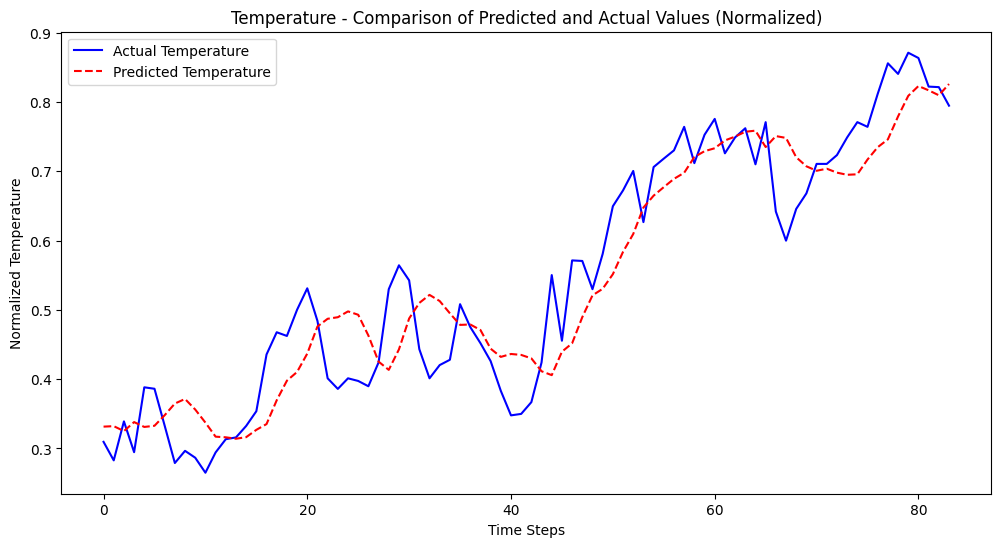

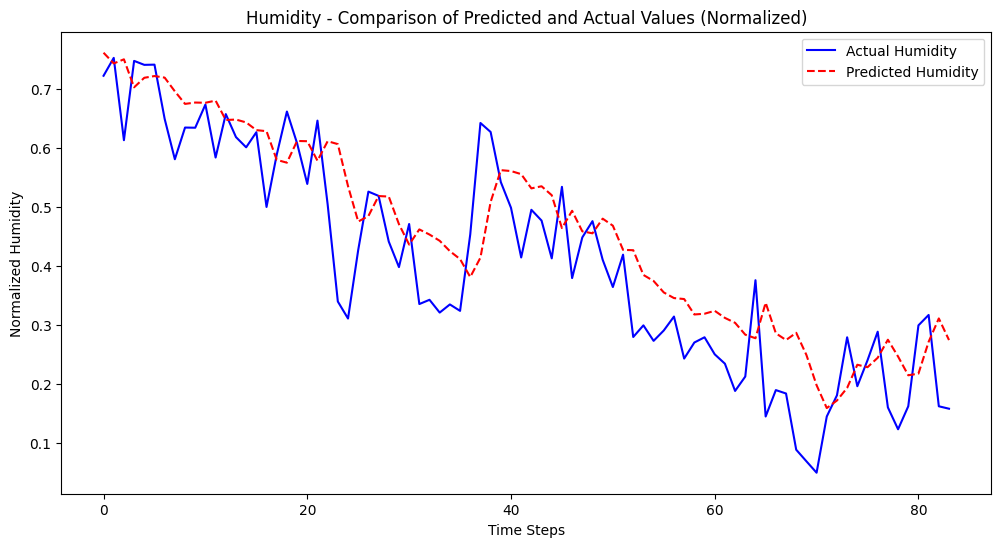

In [4]:

RNNmodel = rnn.MultiFeatureRNN(input_size=2, hidden_size=50, output_size=2).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(RNNmodel.parameters(), lr=0.0001)

RNNmodel,rnn_time = rnn.train_model(train_loader, val_loader, RNNmodel, criterion, optimizer, device)

predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = rnn.evaluate_model(test_loader, RNNmodel, device)

results = {'train_time': rnn_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 
'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[0]] = results

viz.plot_results(predictions, actuals)

In [12]:
ltc_1 = ltc.MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=0.7, tau2=0.7, tau3=0.7).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_1.parameters(), lr=0.001)

ltc_1,ltc1_time,epoch_dx_dt_history = ltc.train_LTC_model(train_loader, val_loader, ltc_1, criterion, optimizer, device)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = ltc.evaluate_LTC_model(test_loader, ltc_1, device)
results = {'train_time': ltc1_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[1]] = results

viz.plot_results(predictions, actuals)

viz.plot_dx_dt_history(epoch_dx_dt_history)

Epoch 1/30, Training Loss: 1470.8886, Validation Loss: 547.9632
Average dx/dt values for each layer: {'layer1': 0.4482971847885185, 'layer2': 1.2696221739881568, 'layer3': 0.9193182500700156}, Average dx/dt value across three layers: 0.8791
Epoch 2/30, Training Loss: 1379.4752, Validation Loss: 810.8332
Average dx/dt values for each layer: {'layer1': 0.8355675439039866, 'layer2': 1.7387372793422804, 'layer3': 0.998877595903145}, Average dx/dt value across three layers: 1.1911
Epoch 3/30, Training Loss: 358.6890, Validation Loss: 543.2173
Average dx/dt values for each layer: {'layer1': 0.9223626090420617, 'layer2': 2.096418955259853, 'layer3': 0.6955077532976348}, Average dx/dt value across three layers: 1.2381


KeyboardInterrupt: 

Epoch 1/30, Training Loss: 0.2334, Validation Loss: 0.1935
Average dx/dt values for each layer: {'layer1': 0.001594247443588554, 'layer2': 0.00025331811533154297, 'layer3': -0.0002290254837539073}, Average dx/dt value across three layers: 0.0005
Epoch 2/30, Training Loss: 0.0774, Validation Loss: 0.0451
Average dx/dt values for each layer: {'layer1': 0.002593490026710141, 'layer2': 0.0013261020657308917, 'layer3': 7.381652242265268e-05}, Average dx/dt value across three layers: 0.0013
Epoch 3/30, Training Loss: 0.0358, Validation Loss: 0.0362
Average dx/dt values for each layer: {'layer1': 0.0032470648325721007, 'layer2': 0.0021851741217283737, 'layer3': 0.0005202782966888561}, Average dx/dt value across three layers: 0.0020
Epoch 4/30, Training Loss: 0.0269, Validation Loss: 0.0223
Average dx/dt values for each layer: {'layer1': 0.0035987901177981663, 'layer2': 0.002392653476110556, 'layer3': 0.0006208401779682996}, Average dx/dt value across three layers: 0.0022
Epoch 5/30, Training 

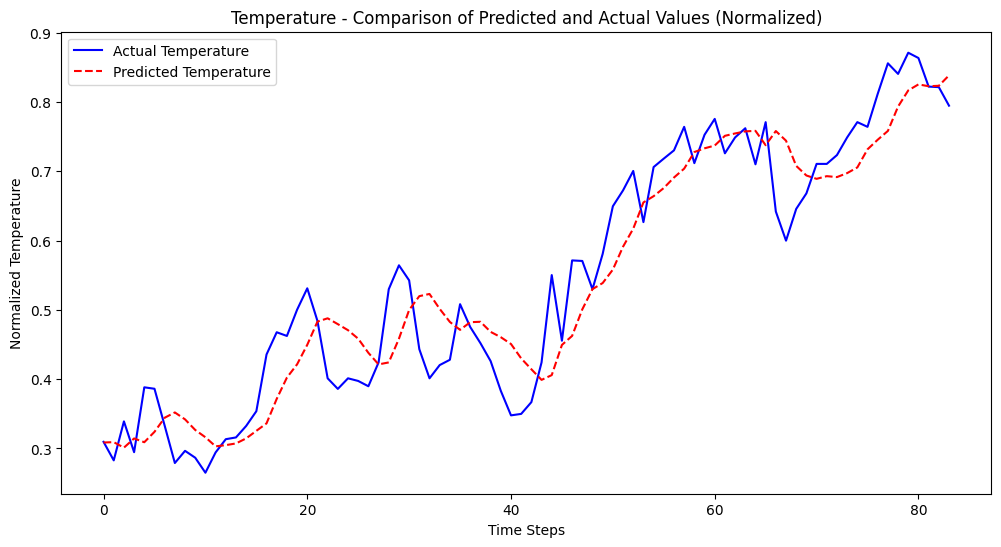

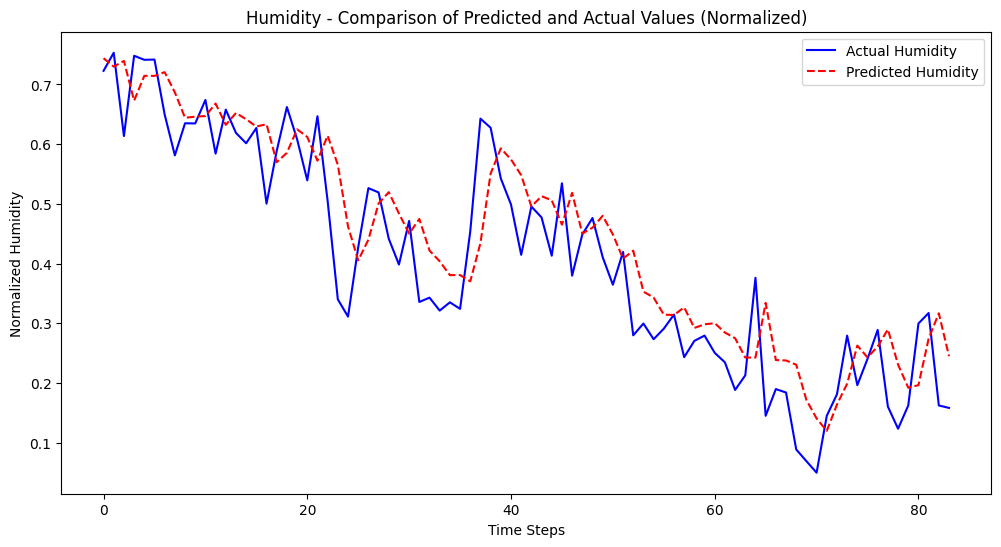

In [6]:
ltc_3 = ltc.MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=10.0, tau2=10.0, tau3=10.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_3.parameters(), lr=0.0001)

ltc_3,ltc3_time,epoch_dx_dt_history = ltc.train_LTC_model(train_loader, val_loader, ltc_3, criterion, optimizer, device)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = ltc.evaluate_LTC_model(test_loader, ltc_3, device)
results = {'train_time': ltc3_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[3]] = results

viz.plot_results(predictions, actuals)

viz.plot_dx_dt_history(epoch_dx_dt_history)

Epoch 1/30, Training Loss: 0.2136, Validation Loss: 0.1206
Average dx/dt values for each layer: {'layer1': 0.004914550065425121, 'layer2': 0.0019242553357293622, 'layer3': 0.0004353027806145191}, Average dx/dt value across three layers: 0.0024
Epoch 2/30, Training Loss: 0.0436, Validation Loss: 0.0336
Average dx/dt values for each layer: {'layer1': 0.0065690937723654015, 'layer2': 0.005313144544036024, 'layer3': 0.0016428656397490865}, Average dx/dt value across three layers: 0.0045
Epoch 3/30, Training Loss: 0.0293, Validation Loss: 0.0271
Average dx/dt values for each layer: {'layer1': 0.006926341706679927, 'layer2': 0.005804203871068441, 'layer3': 0.0019231095712813032}, Average dx/dt value across three layers: 0.0049
Epoch 4/30, Training Loss: 0.0204, Validation Loss: 0.0168
Average dx/dt values for each layer: {'layer1': 0.007340553818115343, 'layer2': 0.006169643544126302, 'layer3': 0.002136510919727799}, Average dx/dt value across three layers: 0.0052
Epoch 5/30, Training Loss: 

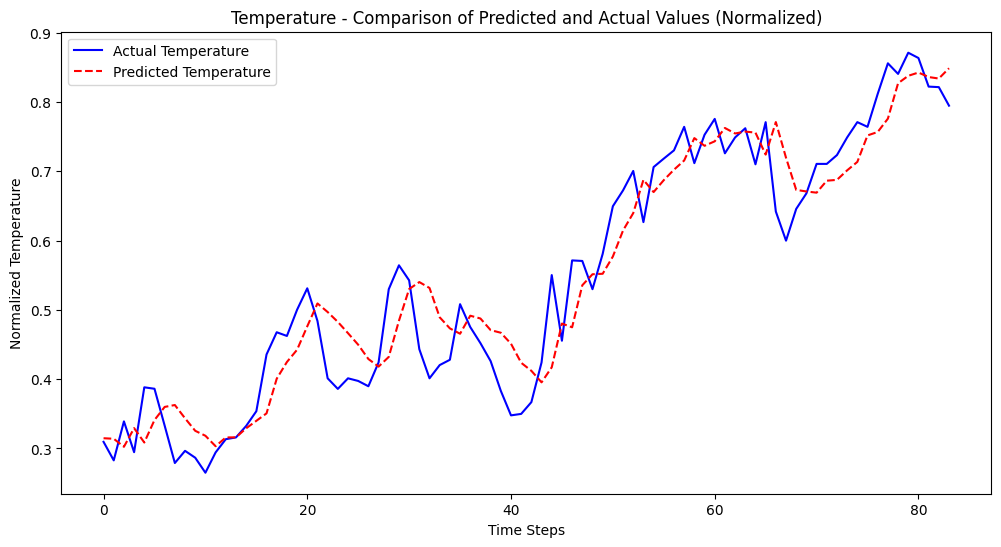

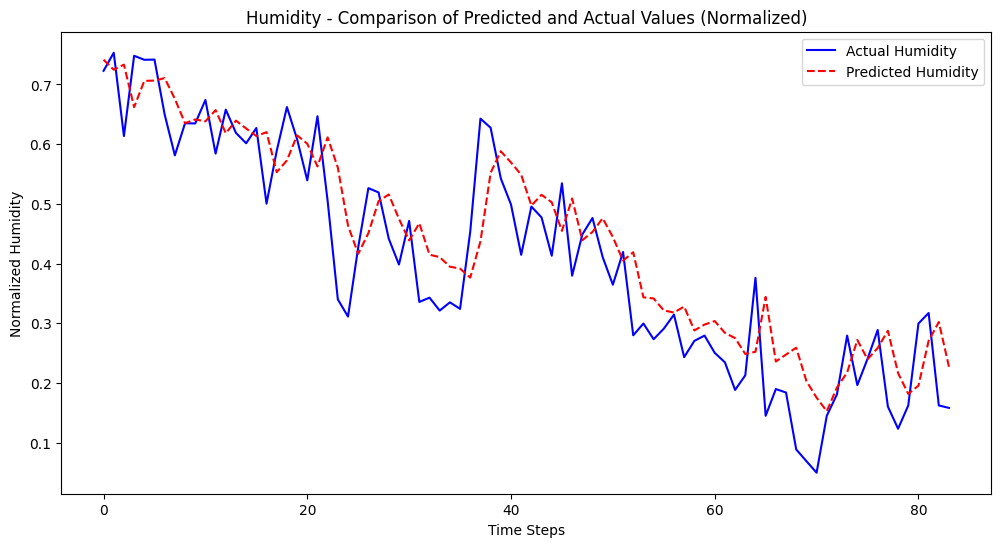

In [7]:

ltc_4 = ltc.MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=100.0, tau2=100.0, tau3=100.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_4.parameters(), lr=0.0001)

ltc_4,ltc4_time,epoch_dx_dt_history = ltc.train_LTC_model(train_loader, val_loader, ltc_4, criterion, optimizer, device)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = ltc.evaluate_LTC_model(test_loader, ltc_4, device)
results = {'train_time': ltc4_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[4]] = results

viz.plot_results(predictions, actuals)

viz.plot_dx_dt_history(epoch_dx_dt_history)

Epoch 1/30, Training Loss: 0.3384, Validation Loss: 0.2811
Average dx/dt values for each layer: {'layer1': 0.001773935618176539, 'layer2': 0.0009156159568293435, 'layer3': 0.0007348227122242355}, Average dx/dt value across three layers: 0.0011
Epoch 2/30, Training Loss: 0.1014, Validation Loss: 0.0319
Average dx/dt values for each layer: {'layer1': 0.00525735236684947, 'layer2': 0.004848266046287285, 'layer3': 0.0019227355240016347}, Average dx/dt value across three layers: 0.0040
Epoch 3/30, Training Loss: 0.0295, Validation Loss: 0.0240
Average dx/dt values for each layer: {'layer1': 0.00812066482871564, 'layer2': 0.007430185660875092, 'layer3': 0.0027838756763635}, Average dx/dt value across three layers: 0.0061
Epoch 4/30, Training Loss: 0.0178, Validation Loss: 0.0143
Average dx/dt values for each layer: {'layer1': 0.009709226924719082, 'layer2': 0.008985918235137232, 'layer3': 0.0031986451908273417}, Average dx/dt value across three layers: 0.0073
Epoch 5/30, Training Loss: 0.012

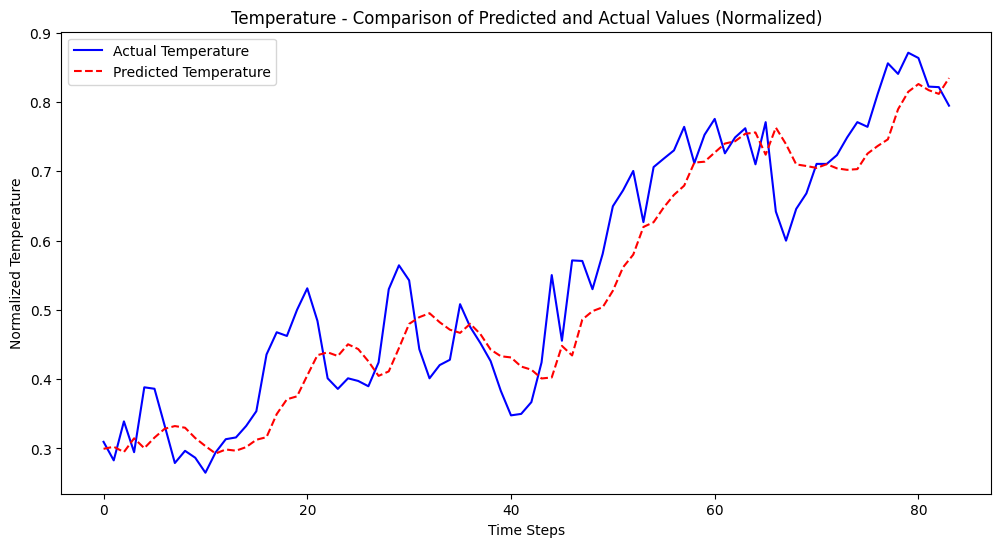

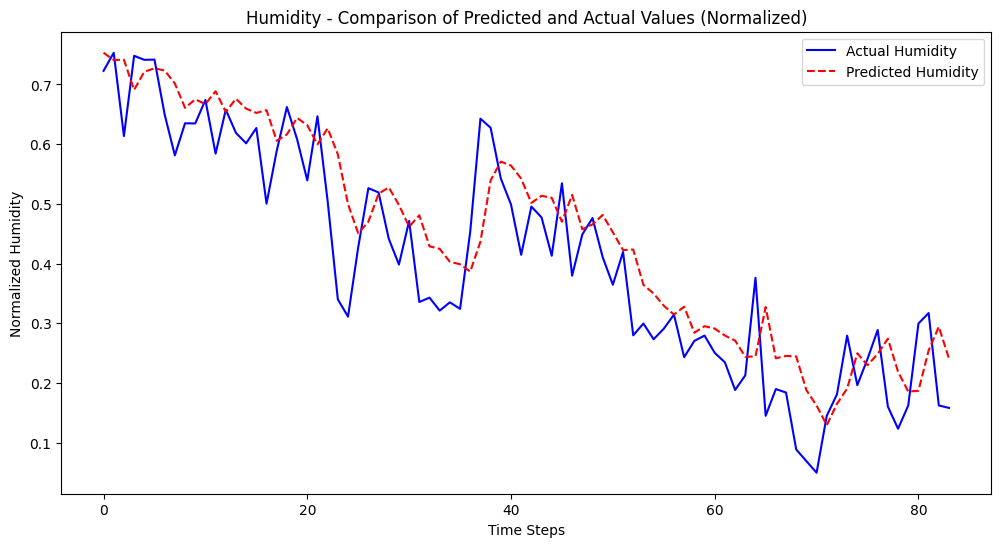

In [8]:

ltc_5 = ltc.MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=1.0, tau2=10.0, tau3=100.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_5.parameters(), lr=0.0001)

ltc_5,ltc5_time,epoch_dx_dt_history = ltc.train_LTC_model(train_loader, val_loader, ltc_5, criterion, optimizer, device)

predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = ltc.evaluate_LTC_model(test_loader, ltc_5, device)
results = {'train_time': ltc5_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[5]] = results

viz.plot_results(predictions, actuals)

viz.plot_dx_dt_history(epoch_dx_dt_history)

In [9]:

viz.visualize_model_results(results_dict)


In [14]:
ltc_6 = ltc.ParallelMultiScaleLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=0.7, tau2=1.0, tau3=10.0, tau4=0.7).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_3.parameters(), lr=0.0001)

ltc_3,ltc3_time,epoch_dx_dt_history = ltc.train_LTC_model(train_loader, val_loader, ltc_3, criterion, optimizer, device)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = ltc.evaluate_LTC_model(test_loader, ltc_3, device)
results = {'train_time': ltc3_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}
results_dict[model_name[3]] = results

viz.plot_results(predictions, actuals)

viz.plot_dx_dt_history(epoch_dx_dt_history)

AttributeError: module 'ltc' has no attribute 'ParallelMultiScaleLTCModel'